In [1]:
import pandas as pd
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas as gpd
import osmnx as ox
import matplotlib.pyplot as plt
pd.options.mode.chained_assignment = None  # default='warn'

crs_fr = 2154
######## check that you only use habitat IRIS #########


In [2]:
### Get relevant shapes and data

# GPM outline
GPM = gpd.read_file('data/raw/GPM.geojson').to_crs(crs_fr)

# Departements GPM codes
departements_GPM = {'Paris' : 'F1175' ,
                    'Essonne' : 'F1191',
                    'Hauts-de-Seine' : 'F1192',
                    'Seine-Saint-Denis' : 'F1193',
                    'Val-de-Marne' : 'F1194',
                    'Val-d\'Oise' : 'F1195'}

# Department GPM shapes
# from https://data.iledefrance.fr/explore/dataset/geoflar-departements/export/
dep = gpd.read_file('data/raw/geoflar-departements/geoflar-departements.shp').to_crs(crs_fr)
dep['nom_dept'] = dep['nom_dept'].apply(lambda x: x.lower())
lowercase_names = dict((k.lower(), v) for k,v in departements_GPM.items())
dep_GPM = dep.loc[dep['nom_dept'].isin(lowercase_names.keys()), ['nom_dept', 'geometry']]

# Paris outline
Paris = ox.geocode_to_gdf("Paris, France").to_crs(crs_fr)

# IRIS codes and shapes 
IRIS_GPM = gpd.read_file('data/processed/GPM_IRIS.geojson').drop(columns=['index_right', 'TYP_IRIS',
       'bbox_north', 'bbox_south', 'bbox_east', 'bbox_west', 'place_id',
       'osm_type', 'osm_id', 'lat', 'lon', 'display_name', 'class', 'type',
       'importance', 'NOM_COM', 'IRIS', 'INSEE_COM'])

# Communes (and filter for GPM)
communes = gpd.read_file('data/raw/commune-frmetdrom/COMMUNE_FRMETDROM.shp').to_crs(crs_fr)
communes['point'] = communes['geometry'].centroid
communes = communes.set_geometry('point')
communes_GPM = gpd.sjoin(communes, GPM, how='inner', op='intersects').set_geometry('geometry')
communes_GPM = communes_GPM[['NOM', 'INSEE_COM', 'geometry']]

/Users/auriane/opt/miniconda3/envs/thesis/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3400: FutureWarning: The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
  if await self.run_code(code, result, async_=asy):


# POI: jobs, education, healthcare
After rescoping, only education is relevant

## JOBS 

Final datset: jobs per IRIS


### Estimations d'emploi (useless due to last dataset)
From https://www.insee.fr/fr/statistiques/6682598?sommaire=4981513#dictionnaire

Folder data/raw/irsocee21_loc2E_csv

“Les Estimations d’emplois sont diffusées selon le statut (salarié ou non), le secteur d’activité, le lieu de travail (région, département, zone d’emploi), le type d’employeur (public ou privé), le sexe et la tranche d’âge” 
-> could help determine job numbers in each commune/departement

In [4]:
# # EUROSTAT
# df = pd.read_csv('data/raw/eurostat.tsv', sep=r'\,|\t') 
# # that weird column is df['geo'r'\t''ime'] 

In [5]:
df_metadata = pd.read_csv('data/raw/irsocee21_loc2E_csv/metadonnees_irsoceenl2021_2E.csv', sep=';')

In [6]:
#T201 – Emploi en fin d'année par département et région de France (hors Mayotte), selon le statut (salarié/non salarié) et le secteur d'activité (A5)
T201 = pd.read_csv('data/raw/irsocee21_loc2E_csv/T201.csv', sep=';') 

# Filtering for 2020, GPM departments, and all sectors combined
T201.loc[(T201['ANNEE2'] == 2020) 
         & (T201['GEO'].isin(departements_GPM.values()))
         & (T201['NA5'] == 'T')] 


# ENS : Emploi total, SAL : Emploi salarié, NSAL : Emploi non salarié

,ANNEE2,NA5,GEO,EFFTOT,STATUT
229,2020,T,F1175,2006281,ENS
328,2020,T,F1191,519455,ENS
361,2020,T,F1192,1163704,ENS
394,2020,T,F1193,692227,ENS
427,2020,T,F1194,586210,ENS
460,2020,T,F1195,432994,ENS
23197,2020,T,F1175,173819,NSAL
23296,2020,T,F1191,38163,NSAL
23329,2020,T,F1192,62644,NSAL
23362,2020,T,F1193,44827,NSAL


In [7]:
# T202 – Emploi salarié en fin d'année par département et région de France (hors Mayotte), selon le secteur d'activité (A38)
T202 = pd.read_csv('data/raw/irsocee21_loc2E_csv/T202.csv', sep=';') 

# Filtering for 2020, GPM departments, and all sectors combined
T202.loc[(T202['ANNEE2'] == 2020) 
         & (T202['GEO'].isin(departements_GPM.values()))
         & (T202['NA38'] == 'T')] 

,ANNEE2,NA38,GEO,EFFSAL
229,2020,T,F1175,1832462
328,2020,T,F1191,481292
361,2020,T,F1192,1101060
394,2020,T,F1193,647400
427,2020,T,F1194,541073
460,2020,T,F1195,397297


In [8]:
# T203 – Emploi salarié en fin d'année par département et région de France (hors Mayotte) selon le secteur d'activité (A5 et A38) et le type d’employeur
T203 = pd.read_csv('data/raw/irsocee21_loc2E_csv/T203.csv', sep=';') 

# Filtering for 2020, GPM departments, and all sectors combined
T203.loc[(T203['ANNEE4'] == 2020) 
         & (T203['GEO'].isin(departements_GPM.values()))
         & (T203['EMPNAF'] == 'ENS')] 

,ANNEE4,EMPNAF,GEO,EFFSAL
22495,2020,ENS,F1175,1832462
22591,2020,ENS,F1191,481292
22623,2020,ENS,F1192,1101060
22655,2020,ENS,F1193,647400
22687,2020,ENS,F1194,541073
22719,2020,ENS,F1195,397297


In [9]:
# T204a – Emploi salarié en fin d'année par département et région de France (hors Mayotte) selon le secteur d'activité (A17) et le sexe
T204a = pd.read_csv('data/raw/irsocee21_loc2E_csv/T204a.csv', sep=';') 

# Filtering for 2020, GPM departments, and all sectors combined
T204a.loc[(T204a['ANNEE4'] == 2020) 
         & (T204a['GEO'].isin(departements_GPM.values()))
         & (T204a['NA17'] == 'T')] 

,ANNEE4,NA17,SEXE,EFFSAL,GEO
223,2020,T,F,942711,F1175
319,2020,T,F,222218,F1191
351,2020,T,F,528157,F1192
383,2020,T,F,291570,F1193
415,2020,T,F,257095,F1194
447,2020,T,F,183126,F1195
74463,2020,T,H,889751,F1175
74559,2020,T,H,259074,F1191
74591,2020,T,H,572903,F1192
74623,2020,T,H,355830,F1193


In [10]:
# T204b – Emploi salarié en fin d'année par département et région de France (hors Mayotte) selon le secteur d'activité (A17) et l’âge
T204b = pd.read_csv('data/raw/irsocee21_loc2E_csv/T204b.csv', sep=';') 

# Filtering for 2020, GPM departments, and all sectors combined
T204b.loc[(T204b['ANNEE3'] == 2020) 
         & (T204b['GEO'].isin(departements_GPM.values()))
         & (T204b['NA17'] == 'T')] 

,ANNEE3,NA17,AGE,EFFSAL,GEO
90,2020,T,A1524,178116,F1175
129,2020,T,A1524,52585,F1191
142,2020,T,A1524,93043,F1192
155,2020,T,A1524,57327,F1193
168,2020,T,A1524,51255,F1194
181,2020,T,A1524,41519,F1195
30250,2020,T,A2549,1164341,F1175
30289,2020,T,A2549,287457,F1191
30302,2020,T,A2549,716214,F1192
30315,2020,T,A2549,408466,F1193


In [11]:
# T205 – Emploi en fin d'année par zone d’emploi de France (hors Mayotte), selon le statut (salarié/non salarié) et le secteur d'activité (A5)
T205 = pd.read_csv('data/raw/irsocee21_loc2E_csv/T205.csv', sep=';') 

# NOTE: this is by zone d'emploi, not by commune
# There are 8 communes from GPM not in the Paris zone d'emploi
# Sevran, Tremblay-en-France, Villepinte, Aulnay-sous-Bois, Le Blanc-Mesnil, Drancy, Le Bourget, Dugny

# Filtering for 2020, GPM communes, and all sectors combined
T205.loc[(T205['ANNEE5'] == 2020) 
        & (T205['GEOZE'] == 'ZER1109')
         & (T205['NA5'] == 'T')] 

,NA5,GEOZE,ANNEE5,STATUT,EFFTOT
4231,T,ZER1109,2020,ENS,4363030
4254,T,ZER1109,2020,NSAL,320133
4277,T,ZER1109,2020,SAL,4042897


#### What is useful here?
- The data by sex -> could help refine the OD matrix
- The data by age -> could help refine the OD matrix
- Apparently, there are more (salaried) jobs according to this dataset than to the other one. 

### Base des zones d'emploi 2020
Data from 2020, revised in 2022
From https://www.insee.fr/fr/information/4652957

Folder data/raw/fonds_ze2020_2022

"Espace géographique à l'intérieur duquel la plupart des actifs résident et travaillent” 
-> proof that GPM is a region worth looking into more than just Paris. Maybe also helps justify why we need connectivity outside of city bounds and rather within metropolis bounds. 

<Axes: >

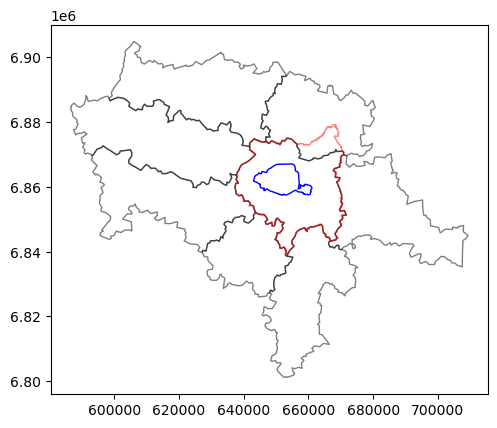

In [12]:
### Get all zones d'emploi of France
employment_zones_fr = gpd.read_file("data/raw/fonds_ze2020_2022/ze2020_2022/ze2020_2022.shp").to_crs(crs_fr)

# Get all zones d'emploi of adjacent to or part of GPM
employment_zones_IDF = gpd.sjoin(employment_zones_fr, GPM, how= 'inner')

# Plot to check
ax = plt.axes()
employment_zones_IDF.plot(ax=ax, facecolor='none', edgecolor='black', alpha = 0.5)
GPM.plot(ax=ax, facecolor='none', edgecolor='red', alpha = 0.5)
Paris.plot( ax=ax, facecolor='none', edgecolor='blue')


###  Inventaire des bases de données relatives à l'emploi 
Set of dataset sources. Could help find more data.
From https://www.data.gouv.fr/fr/datasets/inventaire-des-bases-de-donnees-relatives-a-lemploi/#/resources

File data/raw/inventaire-emploi.csv

In [13]:
df = pd.read_csv('data/raw/inventaire-emploi.csv')

# Only keep those that are "Exploitable", "open to all", "unrestricted"
df_exploitable = df.loc[(df['Format de mise à disposition'] == 'Exploitable')
                               & (df['Liberté d\'accès'] == 'Accès à tous')
                               & (df['Conditions de réutilisation'].notnull())]

# Only keep columns worth exploring
col_tokeep = ['Nom des bases de données', 'Nom du gestionnaire', 'Thématique', 'Type',
               'Portail de mise à disposition', 'Site internet du gestionnaire','Présence data.gouv.fr']

df_exploitable_toexplore = df_exploitable[col_tokeep]

# Only keep non CNRACL data (not about pension of public servants...)
df_exploitable_toexplore = df_exploitable_toexplore[~df_exploitable_toexplore["Nom des bases de données"].str.contains('CNRACL')]

# Only keep non IRCANTEC (another pension thing)
df_exploitable_toexplore = df_exploitable_toexplore[~df_exploitable_toexplore["Nom des bases de données"].str.contains('IRCANTEC')]
df_exploitable_toexplore = df_exploitable_toexplore[~df_exploitable_toexplore["Nom des bases de données"].str.contains('Ircantec')]

In [14]:
df_exploitable_toexplore['Nom des bases de données'].unique()

array(['Les adresses des centres Apec',
       'Nombre agents titulaires et contractuels (FPT et FPH) par département',
       'Aides financières du FIPHFP attribuées aux employeurs publics',
       'Taux d’emploi de travailleurs handicapés dans la fonction publique, selon les régions',
       'Taux emploi de travailleurs handicapés dans la fonction publique, par département',
       'Bénéficiaires de l’Obligation d’Emploi dans la fonction publique',
       'Masses attribuées par le FIPHFP par le biais de conventions aux employeurs publics',
       'Taux d’emploi de travailleurs handicapés dans la fonction publique depuis 2006',
       'Evolution du traitement fonction publique',
       'Evolution de la valeur annuelle moyenne du point de l’indice fonction publique',
       "Mesures exceptionnelles Covid-19 : indemnisation de l'activité partielle des salariés des particuliers employeurs",
       'Aide exceptionnelle « CPSTI RCI COVID-19 »',
       "Nombre d'établissements employeurs et

In [15]:
# A dataset about the number of places that give jobs and how many people work there!
# Get the link
df_exploitable_toexplore.loc[df_exploitable_toexplore['Nom des bases de données'] 
                             == "Nombre d'établissements employeurs et effectifs salariés du secteur privé"]['Portail de mise à disposition'].values[0]

'https://open.urssaf.fr/explore/dataset/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last/information/'

### Number of employing places and number of employed people per commune

From https://open.urssaf.fr/explore/dataset/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last/information/

Should/could be the number of places of employment and the number of employed people per commune/departement/region


In [16]:
df = pd.read_csv('data/raw/etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last.csv', sep=';')

# Fix the Commune names and codes
df['Code commune'] = df.Commune.apply(lambda x: x[:5])
df['Commune'] = df.Commune.apply(lambda x: x[6:])

# Only keep those in GPM
df_GPM = df.loc[df['EPCI'] == 'Métropole du Grand Paris']

# Clean up a bit
col_todrop  = ['Région', 'Ancienne région', 'Département','EPCI',
       'Secteur NA17', 'Secteur NA38', 'Secteur NA88', 'APE', 'Code région',
       'Code ancienne région', 'Code département',
       'Code EPCI', 'Code APE']
df_GPM = df_GPM.drop(col_todrop, axis = 1)

In [17]:
# One row per commune in GPM
df_GPM_grouped = df_GPM.groupby(['Commune' , 'Zone d\'emploi', 'Code zone d\'emploi', 'Code commune']).sum(numeric_only = True).sort_values(by = 'Effectifs salariés 2018').reset_index().drop(0)
df_GPM_grouped.isnull().sum() #Pick 2021

Commune                         0
Zone d'emploi                   0
Code zone d'emploi              0
Code commune                    0
﻿Code commune                   0
Nombre d'établissements 2006    0
Effectifs salariés 2006         0
Nombre d'établissements 2007    0
Effectifs salariés 2007         0
Nombre d'établissements 2008    0
Effectifs salariés 2008         0
Nombre d'établissements 2009    0
Effectifs salariés 2009         0
Nombre d'établissements 2010    0
Effectifs salariés 2010         0
Nombre d'établissements 2011    0
Effectifs salariés 2011         0
Nombre d'établissements 2012    0
Effectifs salariés 2012         0
Nombre d'établissements 2013    0
Effectifs salariés 2013         0
Nombre d'établissements 2014    0
Effectifs salariés 2014         0
Nombre d'établissements 2015    0
Effectifs salariés 2015         0
Nombre d'établissements 2016    0
Effectifs salariés 2016         0
Nombre d'établissements 2017    0
Effectifs salariés 2017         0
Nombre d'établ

In [18]:
# Finish removing useless columns
col_tokeep = ['Commune', 'Code commune', 'Nombre d\'établissements 2021', 'Effectifs salariés 2021']
df_GPM_grouped = df_GPM_grouped[col_tokeep]

# Fix column types
df_GPM_grouped['Code commune'] = df_GPM_grouped['Code commune'].astype('string')
df_GPM_grouped['Commune'] = df_GPM_grouped['Commune'].astype('string')
df_GPM_grouped.dtypes

Commune                          string
Code commune                     string
Nombre d'établissements 2021    float64
Effectifs salariés 2021         float64
dtype: object

In [19]:
# Add geometry to the communes
df_GPM_grouped_with_geom = pd.merge(df_GPM_grouped, communes_GPM, left_on = 'Code commune', right_on = 'INSEE_COM', how = 'left')
df_GPM_grouped_with_geom = gpd.GeoDataFrame(df_GPM_grouped_with_geom, geometry = 'geometry')

In [20]:
# Final Clean-up
col_tokeep = ['Commune', 'Code commune', 'Nombre d\'établissements 2021',
       'Effectifs salariés 2021', 'geometry']
jobs_per_commune = df_GPM_grouped_with_geom[col_tokeep]

<Axes: >

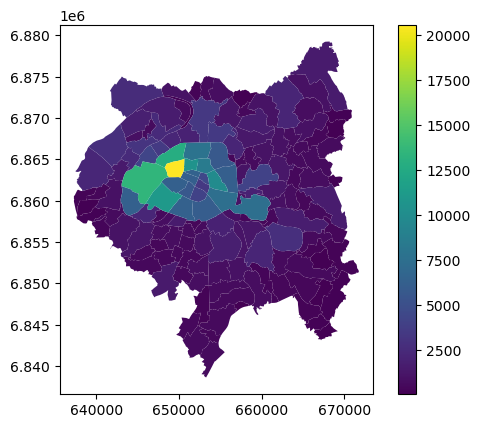

In [21]:
jobs_per_commune.plot(column = 'Nombre d\'établissements 2021', legend = True)

<Axes: >

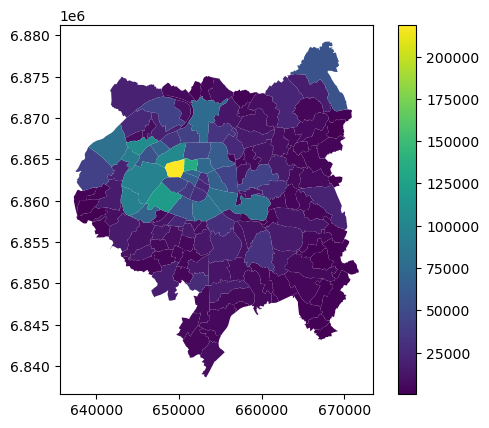

In [22]:
jobs_per_commune.plot(column = 'Effectifs salariés 2021', legend = True)

<Axes: >

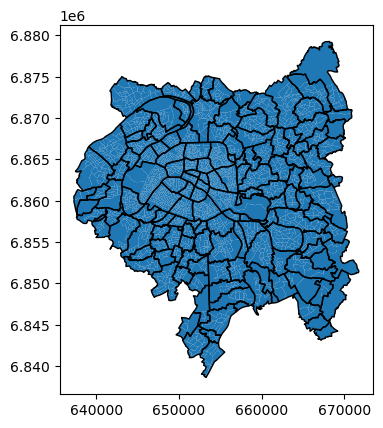

In [23]:
#--- Now on to IRIS level

# Prep the data for spatial join
jobs_per_commune = jobs_per_commune.to_crs(IRIS_GPM.crs)
IRIS_GPM['representative_point'] = IRIS_GPM.representative_point()
IRIS_GPM = IRIS_GPM.set_geometry('representative_point')

# Spatial join
IRIS_communes_GPM = gpd.sjoin(jobs_per_commune, IRIS_GPM, how= 'inner').drop(columns=['index_right'])
IRIS_communes_GPM = IRIS_communes_GPM.set_geometry('geometry_right')

# Plot to check if it worked
ax = plt.axes()
IRIS_communes_GPM.plot(ax=ax)
jobs_per_commune.plot(ax=ax, facecolor='none')

<Axes: >

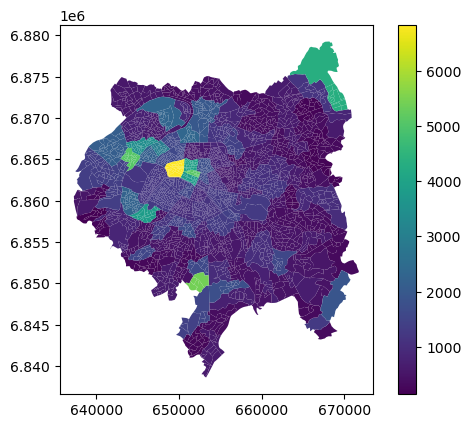

In [24]:
#--- Turning commune-level numbers into IRIS-level numbers

# Calculate the number of IRIS in each commune
IRIS_communes_GPM['Nombre d\'IRIS'] = IRIS_communes_GPM.groupby(['Commune'])['CODE_IRIS'].transform('count')

# Divide the number of jobs in each commune by the number of IRIS in the commune
IRIS_communes_GPM['Effectifs salariés 2021 par IRIS'] = IRIS_communes_GPM['Effectifs salariés 2021'] / IRIS_communes_GPM['Nombre d\'IRIS']
IRIS_communes_GPM['Nombre d\'établissements 2021 par IRIS'] = IRIS_communes_GPM['Nombre d\'établissements 2021'] / IRIS_communes_GPM['Nombre d\'IRIS']

# Plot the number of jobs per IRIS
IRIS_communes_GPM.plot(column = 'Effectifs salariés 2021 par IRIS',legend = True)


In [25]:
#--- Create the final jobs per IRIS dataset

col_tokeep = ['CODE_IRIS', 'Effectifs salariés 2021 par IRIS', 'Nombre d\'établissements 2021 par IRIS']
jobs_per_IRIS = IRIS_communes_GPM[col_tokeep]
jobs_per_IRIS = jobs_per_IRIS.astype('int64')

jobs_per_IRIS.head(1)

,CODE_IRIS,Effectifs salariés 2021 par IRIS,Nombre d'établissements 2021 par IRIS
0,940560000,341,46


In [26]:
total_jobs_GPM = jobs_per_IRIS['Effectifs salariés 2021 par IRIS'].sum()
total_jobs_GPM

3414459

## EDUCATION

Final dataset: higher education, schools and kindergartens per IRIS

In [27]:
#--- Get education-related amenities from OSM

# Define tags
tags = {'amenity': ['university', 'school', 'kindergarten', 'college', 'trade_school']}
place_name = 'Grand Paris Metropolis, France'

# Get the data
buildings = ox.geometries_from_place(place_name, tags).reset_index(drop=False)

# Keep relevant columns
col_tokeep = ['osmid', 'geometry', 'amenity', 'name', 'school:FR']
buildings = buildings[col_tokeep].to_crs(IRIS_GPM.crs)
buildings.shape


(5627, 5)

In [28]:
# Only keep buildings with some sort of name (so they can be checked)
buildings['name'] = buildings['name'].fillna(buildings['school:FR'])
buildings_notnull = buildings.loc[buildings['name'].notnull()].drop_duplicates(subset=['geometry'], keep='first').drop(columns = ['school:FR', 'osmid'])
len(buildings_notnull)

5457

In [29]:
### Group by type and by IRIS

# Prep the tables
buildings_notnull['geometry'] = buildings_notnull['geometry'].centroid
buildings_notnull = buildings_notnull.drop(columns = 'name')
IRIS_GPM = IRIS_GPM.set_geometry('geometry').drop(columns = ['NOM_IRIS', 'representative_point'])

# Perform the spatial join
joined_table = gpd.sjoin(buildings_notnull, IRIS_GPM, how = 'right', predicate='within')

# Find buildings that are close to the border
unmatched_buildings = buildings_notnull[~buildings_notnull.index.isin(joined_table['index_left'])]
buffer_distance = 50 
unmatched_buildings['geometry'] = unmatched_buildings.buffer(buffer_distance)
buffer_gdf = gpd.GeoDataFrame(unmatched_buildings ,geometry='geometry', crs=buildings_notnull.crs)

# Add missing buildings to the table
buffer_joined_table = gpd.sjoin(buffer_gdf, IRIS_GPM, how = 'right')
buffer_joined_table.isnull().sum()
joined_table = pd.concat([joined_table, buffer_joined_table], ignore_index=True).drop(columns = ['index_left'])

# Count the number of each building amenity in each IRIS
pivot_table = joined_table.pivot_table(index='CODE_IRIS', columns='amenity', aggfunc='count', fill_value=0)
pivot_table.columns = pivot_table.columns.map(lambda x: f'{x[1]}_count')
pivot_table = pivot_table.reset_index()

# Add up the university and college counts into one column
pivot_table['higher_edu_count'] = pivot_table['college_count'] + pivot_table['university_count']

# Drop the university and college columns
pivot_table = pivot_table.drop(columns = ['college_count', 'university_count'])

# Add geometry
final_table = pivot_table.merge(IRIS_GPM[['CODE_IRIS', 'geometry']], on='CODE_IRIS', how = 'right').fillna(0)

# turn everything except the geometry to int64 type
final_table.iloc[:, 0:-1] = final_table.iloc[:, 0:-1].astype('int64')

education_pertype_perIRIS = final_table

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_87334/860810230.py:37: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final_table.iloc[:, 0:-1] = final_table.iloc[:, 0:-1].astype('int64')


## HEALTHCARE

Final dataset: pharmacies and doctors per IRIS

In [30]:
#--- Get health-related amenities from OSM

# Define tags
tags = {'amenity': ['doctors', 'pharmacy']}

# Get the data
buildings = ox.geometries_from_place(place_name, tags).reset_index(drop=False)

# Keep relevant columns
col_tokeep = ['osmid', 'geometry', 'amenity', 'name']
buildings = buildings[col_tokeep].to_crs(IRIS_GPM.crs) 

# Only keep buildings with some sort of name (so they can be checked)
buildings_notnull = buildings.loc[buildings['name'].notnull()].drop_duplicates(subset=['geometry'], keep='first').drop(columns = ['osmid', 'name'])

In [31]:
#--- Group by type and by IRIS

# Prep the tables
buildings_notnull['geometry'] = buildings_notnull['geometry'].centroid

# Perform the spatial join
joined_table = gpd.sjoin(buildings_notnull, IRIS_GPM, how = 'right', predicate='within')

# Count the number of doctors and pharmacies respectively in each IRIS
pivot_table = joined_table.pivot_table(index='CODE_IRIS', columns='amenity', aggfunc='count', fill_value=0).drop(columns = 'index_left')
pivot_table.columns = pivot_table.columns.map(lambda x: f'{x[1]}_count')
pivot_table = pivot_table.reset_index()

# Add geometry
final_table = pivot_table.merge(IRIS_GPM[['CODE_IRIS', 'geometry']], on='CODE_IRIS', how = 'right').fillna(0)
# turn everything except the geometry to int64 type
final_table.iloc[:, 0:-1] = final_table.iloc[:, 0:-1].astype('int64')
final_table

# Turn into GeoDataFrame
healthcare_pertype_perIRIS = gpd.GeoDataFrame(final_table, geometry = 'geometry')

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_87334/580340772.py:17: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  final_table.iloc[:, 0:-1] = final_table.iloc[:, 0:-1].astype('int64')


## Combine all job/education/healthcare
Final dataset: kindergartens, schools, higher education places, pharmacies, doctors and jobs per IRIS

In [32]:
#--- Create a table with all education, jobs, and healthcare data

# Merge the education and healthcare tables
education_healthcare_perIRIS = education_pertype_perIRIS.merge(healthcare_pertype_perIRIS, on = 'CODE_IRIS', how = 'outer').fillna(0).drop(columns = 'geometry_x')

# Merge the education/healthcare table with the jobs table
education_healthcare_jobs_perIRIS = education_healthcare_perIRIS.merge(jobs_per_IRIS, on = 'CODE_IRIS', how = 'outer').fillna(0).rename(columns = {'geometry_y': 'geometry',
                                                                                                                                                   'Effectifs salariés 2021 par IRIS': 'num_employed_people',
                                                                                                                                                   'Nombre d\'établissements 2021 par IRIS' : 'num_employment_establishments'})
education_healthcare_jobs_perIRIS = gpd.GeoDataFrame(education_healthcare_jobs_perIRIS, geometry = 'geometry')


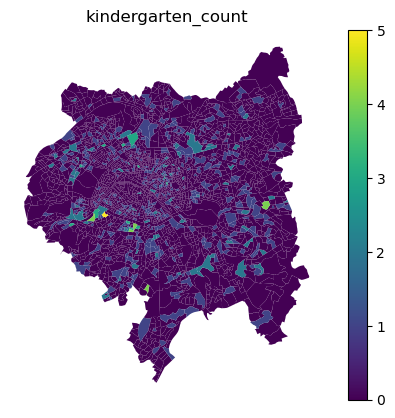

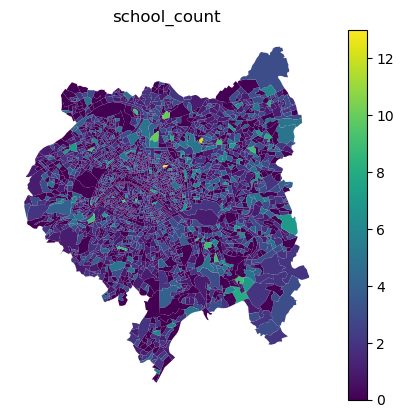

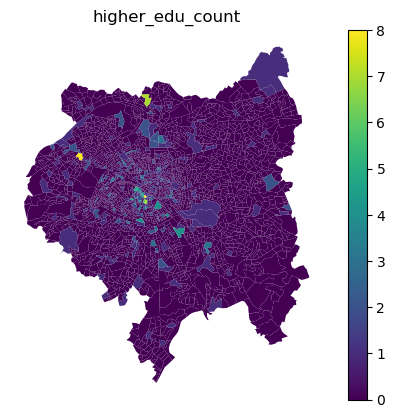

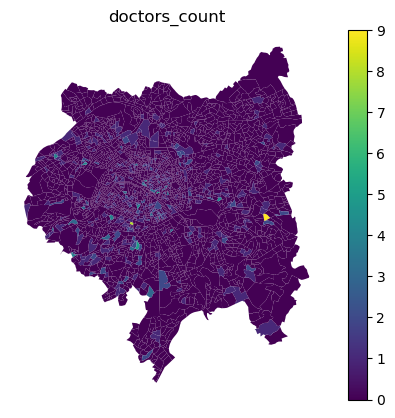

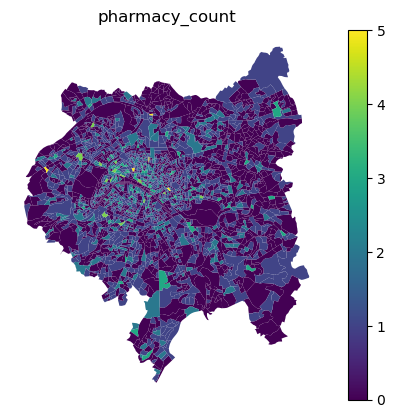

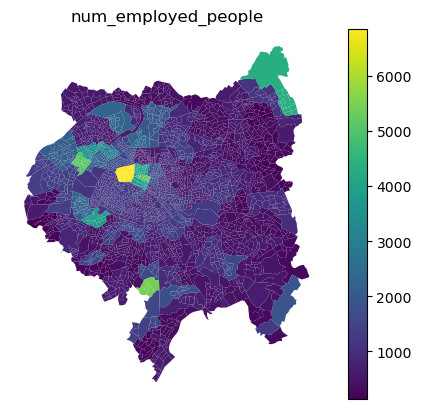

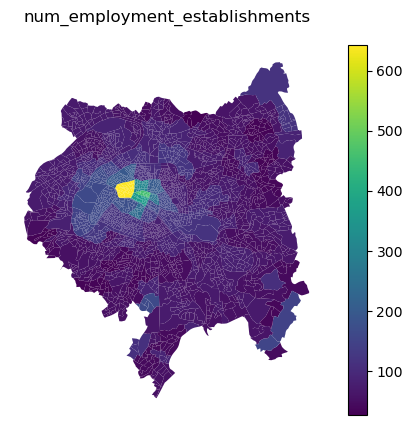

In [33]:
#--- Plot Everything

col_toplot = ['kindergarten_count', 'school_count', 'higher_edu_count',
       'doctors_count', 'pharmacy_count', 'num_employed_people',
       'num_employment_establishments']

for col in col_toplot:
    ax = plt.axes()
    ax.axis('off')
    ax.set_title(col)
    education_healthcare_jobs_perIRIS.plot(column = col, legend = True, ax =ax)
    plt.savefig(f'./figures/{col}.png')
    plt.show()


In [34]:
# NEW: We only need age ranges and  school locations
# Only keep the columns we need
col_tokeep = ['CODE_IRIS', 'school_count', 'geometry']
education_perIRIS = education_healthcare_jobs_perIRIS[col_tokeep]
education_perIRIS.head(2)

,CODE_IRIS,school_count,geometry
0,751114113,2,"POLYGON ((654130.100 6863650.800, 654171.300 6..."
1,920440109,3,"POLYGON ((648086.800 6866229.600, 648055.600 6..."


In [35]:
#--- Combine age ranges and school locations
merged = age_range_IRIS.merge(education_perIRIS, left_on = 'IRIS', right_on = 'CODE_IRIS', how = 'outer')
merged = gpd.GeoDataFrame(merged, geometry = 'geometry')
merged.plot(column = 'school_count', legend = True)

NameError: name 'age_range_IRIS' is not defined

# Transport poverty dimensions
After rescoping, only accessibility is necessary

## Affordability metrics
Not needed anymore due to rescoping

In [ ]:
# TODO where is this from? Formatting and documentation in markdown as above!!
df = pd.read_csv('data/raw/IRIS_DATA/BASE_TD_FILO_DISP_IRIS_2019.csv', sep = ';')
df_meta = pd.read_csv('data/raw/IRIS_DATA/meta_BASE_TD_FILO_DISP_IRIS_2019.csv', sep = ';').drop_duplicates(subset = 'COD_VAR')

vars_of_interest = ['IRIS',
                    # 'DISP_TP6019', # Taux de pauvreté au seuil de 60 % (%)
                    'DISP_MED19', # Revenu médian (euros) par UC
                    # 'DISP_Q119', # 1er quartile (euros) par UC
                    # 'DISP_Q319', # 3e quartile (euros) par UC
                    # 'DISP_EQ19', # Écart inter-quartile rapporté à la médiane par UC
                    # 'DISP_GI19', # Indice de Gini based on UC?
                    ]

df_meta_vars = df_meta.loc[df_meta['COD_VAR'].isin(vars_of_interest)].drop_duplicates(subset = 'COD_VAR')
median_income_IRIS_GPM = df.loc[(df['IRIS'].isin(IRIS_GPM['CODE_IRIS'])), df_meta_vars['COD_VAR'].values]

### Median Income (per Unit of consumption)
From: INSEE (link??)

Final dataset: median income per IRIS 

Missing values filled with incomedata on communal level, assigned to each IRIS within the commune with missing values

From: INSEE https://www.insee.fr/fr/statistiques/6036907#consulter



In [ ]:
# Add geometry to the dataframe
median_income_IRIS_GPM_geom = median_income_IRIS_GPM.merge(IRIS_GPM[['CODE_IRIS', 'geometry']], left_on = 'IRIS', right_on = 'CODE_IRIS', how = 'outer')
median_income_IRIS_GPM_geom = gpd.GeoDataFrame(median_income_IRIS_GPM_geom, geometry = 'geometry')
median_income_IRIS_GPM_geom.isnull().sum()

IRIS          189
DISP_MED19    189
CODE_IRIS       0
geometry        0
dtype: int64

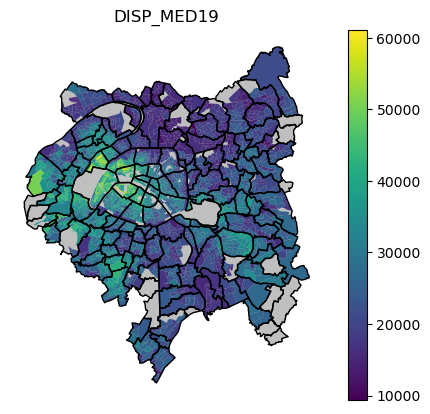

In [ ]:
# Plot for test
col_toplot = [#'DISP_TP6019',
               'DISP_MED19',
                #  'DISP_GI19',
                 ]

for col in col_toplot:
    ax = plt.axes()
    ax.axis('off')
    ax.set_title(col)
    IRIS_GPM.plot(facecolor = 'grey', ax=ax, alpha = 0.5)
    median_income_IRIS_GPM_geom.plot(column = col, legend = True, ax =ax)
    communes_GPM.plot(facecolor = 'none', edgecolor = 'black', ax=ax)
    plt.show()


#### Fill missing values using communal data (level higher than IRIS)

In [ ]:
df = pd.read_csv('data/raw/indic-struct-distrib-revenu-2019-COMMUNES_csv/FILO2019_DISP_COM.csv', sep = ';')
df_meta = pd.read_csv('data/raw/indic-struct-distrib-revenu-2019-COMMUNES_csv/meta_FILO2019_DISP_COM.csv', sep = ';')

/var/folders/2m/lkz691q11b72bpprh6_v34_h0000gn/T/ipykernel_87001/2312607251.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('data/raw/indic-struct-distrib-revenu-2019-COMMUNES_csv/FILO2019_DISP_COM.csv', sep = ';')


In [ ]:
vars_of_interest = ['CODGEO', #geographical code
                    'Q219' #median
                    ]

df['CODGEO'] = df['CODGEO'].astype(str)
median_income_commune_GPM = df.loc[ df['CODGEO'].isin(communes_GPM['INSEE_COM'].tolist()), vars_of_interest]

# Add commune geometry to the dataframe
median_income_commune_GPM = median_income_commune_GPM.merge(communes_GPM[['INSEE_COM', 'geometry']], left_on = 'CODGEO', right_on = 'INSEE_COM', how = 'outer').drop(columns = 'INSEE_COM')
median_income_commune_GPM = gpd.GeoDataFrame(median_income_commune_GPM, geometry = 'geometry')    
median_income_commune_GPM.head(2)

,CODGEO,Q219,geometry
0,75101,34720,"POLYGON ((651927.100 6861781.900, 651911.600 6..."
1,75102,32650,"POLYGON ((652102.700 6863620.200, 652167.800 6..."


<Axes: >

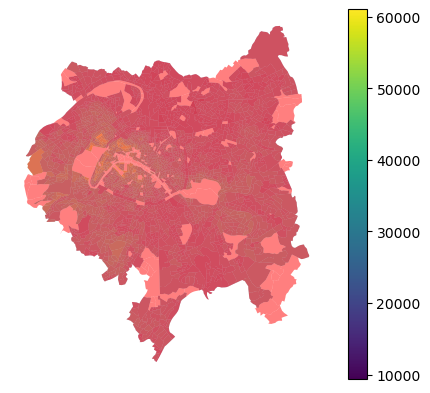

In [ ]:
#--- Match IRIS and communes

# Prep the data for spatial join
median_income_IRIS_GPM_geom['representative_point'] = median_income_IRIS_GPM_geom.representative_point()
median_income_IRIS_GPM_geom = median_income_IRIS_GPM_geom.set_geometry('representative_point')

# Spatial join
joined = gpd.sjoin(median_income_IRIS_GPM_geom, median_income_commune_GPM, how= 'inner')
joined = joined.set_geometry('geometry')
median_income_IRIS_GPM_geom = median_income_IRIS_GPM_geom.set_geometry('geometry')

# Plot for check
ax = plt.axes()
ax.axis('off')
median_income_IRIS_GPM_geom.plot(legend = True, column = 'DISP_MED19', ax =ax, alpha = 0.5)
joined.plot(ax=ax, facecolor = 'red', alpha = 0.5)


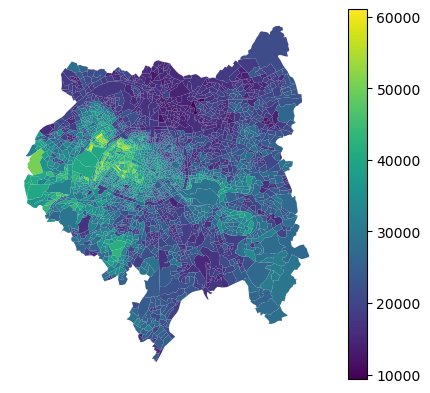

In [ ]:
#--- Create final dataframe with lemdian income

# Fill-in the missing data
joined['DISP_MED19'] = joined['DISP_MED19'].fillna(joined['Q219'])

# Final clean-up
median_income_IRIS_GPM_complete = joined[['CODE_IRIS', 'DISP_MED19', 'geometry']]
median_income_IRIS_GPM_complete = median_income_IRIS_GPM_complete.rename(columns = {'DISP_MED19': 'median_income'})

ax = plt.axes()
ax.axis('off')
median_income_IRIS_GPM_complete.plot(column = 'median_income', legend = True, ax=ax)
plt.savefig(f'./figures/median_income.png')

### Poverty line

In [ ]:
#--- Which IRIS are below the poverty line before transport?
poverty_line= median_income_IRIS_GPM_complete.median_income.median()*0.6
median_income_IRIS_GPM_complete['poverty_before_transport'] = median_income_IRIS_GPM_complete['median_income'] < poverty_line


#### Public transport costs for an entire household
Average size of households per departement: from https://www.insee.fr/fr/statistiques/2012714

Final dataset: median income in each IRIS after paying for transport for the whole household

In [ ]:
#--- Cost of transport for the avg household in each IRIS

#  Get the avg household size per departement
df = pd.read_excel('data/raw/TCRD_006.xlsx')
avg_household_size_dep_GPM = df.loc[df['Departement'].isin(departements_GPM.keys()), ['Departement', 'Nombre moyen de personnes par ménage']].rename(columns = {'Nombre moyen de personnes par ménage': 'avg_household_size'})

# Calculate the cost of transport for the avg household in each departement
# For adults: 84€/month, = 1008€/year (flatrate RATP)
avg_household_size_dep_GPM['transport_cost'] = avg_household_size_dep_GPM['avg_household_size'] * 1008

In [ ]:
#--- Combine with the median income data

# Add geometry to the dataframe
avg_household_size_dep_GPM['Departement'] = avg_household_size_dep_GPM['Departement'].str.lower()
avg_household_size_dep_GPM = avg_household_size_dep_GPM.merge(dep_GPM, left_on = 'Departement', right_on = 'nom_dept', how = 'outer')
avg_household_size_dep_GPM = gpd.GeoDataFrame(avg_household_size_dep_GPM, geometry = 'geometry')

# Match IRIS and departements
# Prep the data for spatial join
median_income_IRIS_GPM_complete['representative_point'] = median_income_IRIS_GPM_complete.representative_point()
median_income_IRIS_GPM_complete = median_income_IRIS_GPM_complete.set_geometry('representative_point')

# Spatial join
joined = gpd.sjoin(median_income_IRIS_GPM_complete, avg_household_size_dep_GPM, how= 'inner')
joined = joined.set_geometry('geometry')


In [ ]:
#--- Calculate the cost of transport as a percentage of the median income

# TODO FIX THIS
# joined['transport_cost_as_%_of_median_income'] = joined['transport_cost'] / joined['median_income'] * 100
joined['transport_cost_as_%_of_median_income'] = 1008 / joined['median_income'] * 100

joined['transport_above_10%_income'] = joined['transport_cost_as_%_of_median_income'] > 10


# joined['poverty_after_transport'] = (joined['median_income'] - joined['transport_cost']) < poverty_line
joined['poverty_after_transport'] = (joined['median_income'] - 1008) < poverty_line

In [ ]:
joined.head(1)

,CODE_IRIS,median_income,geometry,poverty_before_transport,representative_point,index_right,Departement,avg_household_size,transport_cost,nom_dept,transport_cost_as_%_of_median_income,transport_above_10%_income,poverty_after_transport
0,751010201,30010.0,"POLYGON ((652324.600 6862635.300, 652293.600 6...",False,POINT (652222.144 6862546.900),0,paris,1.9,1915.2,paris,3.35888,False,False


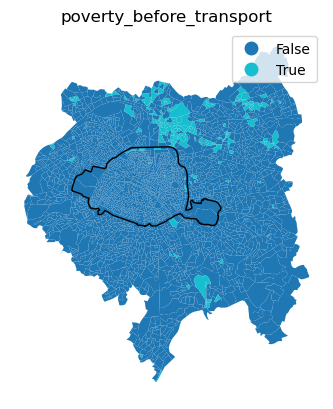

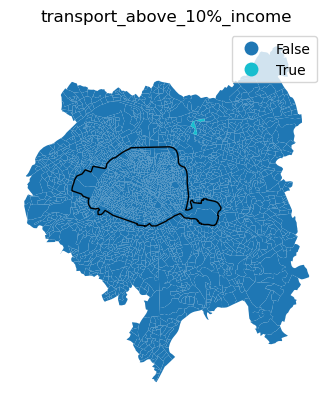

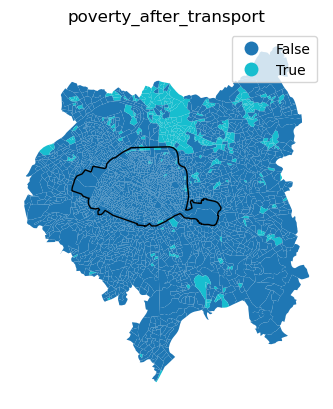

In [ ]:
#--- Final cleanup
median_income_poverty_line_post_transport_cost_IRIS_GPM = joined[['CODE_IRIS',
                                                                'poverty_before_transport',
                                                                'transport_above_10%_income',
                                                                'poverty_after_transport',
                                                                'geometry'
                                                                 ]]

# Plot everything
col_toplot =['poverty_before_transport',
            'transport_above_10%_income',
            'poverty_after_transport'
             ]

for col in col_toplot:
    ax = plt.axes()
    ax.axis('off')
    median_income_poverty_line_post_transport_cost_IRIS_GPM.plot(column = col, legend = True, ax=ax)
    Paris.plot(facecolor = 'none', edgecolor = 'black', ax=ax)

    plt.title(col)
    plt.savefig(f'./figures/{col}.png')
    plt.show()

## Mobility Metrics
Not needed anymore due to rescoping

## Accessibility Metrics
Dual measure: How long does it take to go to the closest destination of interest?

Logic: A dual measure of accessibility looks at how long it takes an individual to reach the closest X number of destinations. Since we only focus on schools, and we assume that everything is at a centroid (the kids and the school) the idea behind the measure of accessibility becomes quite simple: Get the kids from IRIS without schools to IRIS with schools, preferrably by bike, and the kids with longer travel times are prioritised. 

Since there is no data on distribution of the population below the level of IRIS, I have to put them in centroids. This would lead to creating bike paths from each centroid to its own schools, but this might be completely irrelevant to the people living in the area since we don't know whether the centroid is a relevant location in the IRIS. For this level of development, it might be easier to use the growing networks from scratch approach as explained by Szell. 

In [ ]:
merged['P19_POP_SCHOOL'] = merged['P19_POP_SCHOOL'].astype('int')

<Axes: >

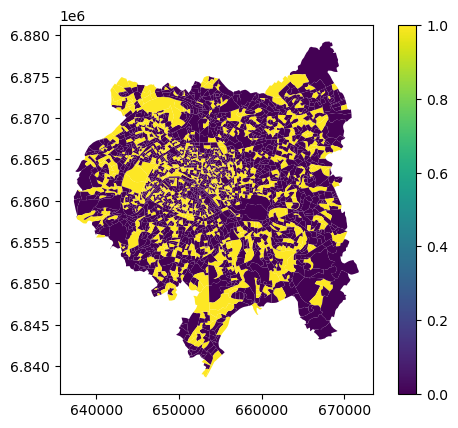

In [ ]:
#--- Easiest version: if you have a school your vulnerability is 0, if you don't then it is 1. 
# Add this to the merged dataframe
merged['vulnerability_simple'] = merged['CODE_IRIS'].isin(merged.loc[(merged['school_count']==0) &
                                                              (merged['P19_POP_SCHOOL'] > 0)]['CODE_IRIS'].tolist())
merged['vulnerability_simple'] = merged['vulnerability'].astype(int)
merged.plot(column = 'vulnerability_simple', legend = True)

<Axes: >

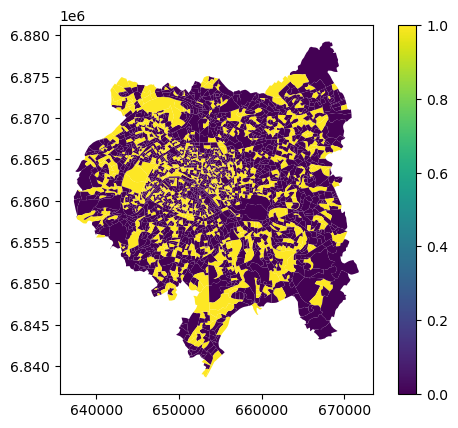

In [ ]:
#--- More complicated version: Calculate the travel time to the nearest school

# Start by calculating the travel time to all schools

# Continue by taking the minimum travel time to a school

# Normalize results (0 travel = 0 vulnerability, max travel = 1 vulnerability)

# Add to the merged dataframe

# Plot results


In [ ]:
# # option 1

# # A lambda to check if the list of paths includes certain nodes
# only_containing_nodes = lambda x: 'd' in x and 'k' in x

# # If you want to find the shortest path which includes those nodes this
# # will get all the paths and then they can be filtered and ordered by
# # their length.
# all_simple_paths = nx.all_simple_paths(G, source='a', target='k')

# # If you only want shortest paths which include both nodes even if a
# # path includes the nodes and is not the shortest.
# all_shortest_paths = nx.all_shortest_paths(G, source='a', target='k')

# filter(only_containing_nodes, all_simple_paths)
# # >>> [['a', 'b', 'c', 'd', 'e', 'g', 'k']]

# filter(only_containing_nodes, all_shortest_paths)
# # >>> []


In [ ]:
# recreate the network

# For each destination
# create a list of nodes with the necessary destination attribute
# i.e one list for uni, schools, GP, pharmacy, job, kindergarten 


# For each centroid
# Look for the 5 closest nodes with destination of interest
# Find shortest path from the centroid to the 5 closest nodes
# Pick shortest path 

In [ ]:
# TODO where is this from? 
#--- Get data on the age ranges of the population 

df = pd.read_csv('data/raw/struct-pop-2019/struct-pop-2019.CSV', sep = ';')
df_meta = pd.read_csv('data/raw/struct-pop-2019/meta-struct-pop-2019.CSV', sep = ';')
df['IRIS'] = df['IRIS'].astype('str')

vars_of_interest = ['IRIS',
                    'P19_POP', # Total population
                    'P19_POP0305', # Population 3-5 years old -> goes to school
                    'P19_POP0610', # Population 6-10 years old -> goes to school
                    'P19_POP1117', # Population 11-17 years old -> goes to school                    
                    ]

df_meta_vars = df_meta.loc[df_meta['COD_VAR'].isin(vars_of_interest)].drop_duplicates(subset = 'COD_VAR')
df_narrow_IRIS = df.loc[(df['IRIS'].isin(IRIS_GPM['CODE_IRIS'])), df_meta_vars['COD_VAR'].values]

# Combine all age groups that go to school into one column
df_narrow_IRIS['P19_POP_SCHOOL'] = df_narrow_IRIS['P19_POP0305'] + df_narrow_IRIS['P19_POP0610'] + df_narrow_IRIS['P19_POP1117']

# Remove the columns that were combined
age_range_IRIS = df_narrow_IRIS.drop(columns = ['P19_POP0305', 'P19_POP0610', 
                                                'P19_POP1117'])
age_range_IRIS['IRIS'] = age_range_IRIS['IRIS'].astype('int')

NameError: name 'pd' is not defined

In [ ]:
df

# Final dataset for centroid data
- Number of school age kids in the IRIS
- Total population of the IRIS
- Number of schools in the IRIS
- Accessbility score of the IRIS
- Geometry of the IRIS

# OLD

In [ ]:
# ### OLD, THE API SUCKS
# # Get the data from the API

# #Get the first 10000 rows (somehow I can't get more?!)
# url = 'https://open.urssaf.fr/api/records/1.0/search/?dataset=etablissements-et-effectifs-salaries-au-niveau-commune-x-ape-last&q=&rows10000&facet=departement&facet=zone_d_emploi&facet=intitule_commune&facet=grand_secteur_d_activite&facet=secteur_na17&facet=secteur_na38&facet=secteur_na88&facet=code_departement&facet=code_zone_d_emploi&facet=code_commune&refine.region=%C3%8Ele-de-France'
# response = json.loads(requests.get(url).text)

# full_dict = {}
# for idx, item in enumerate(response['records']):
#     full_dict[idx] = item['fields']

# pd.DataFrame.from_dict(full_dict, orient = 'index')